# TDVP numerical test \#1

The goal is to use the TDVP to simulate the time evolution of a simple Hamiltonian, when state space is restricted to some manifold Furthermore a goal is to compare this method with directly solving the SE and projecting to the manifold.

The first example will be $\mathcal{M}= S^2$ and $H=\sigma_x$ to generate an X-rotation of a 1-qubit system. Note that the Bloch-sphere is a restriction of the entire 2-dim $\mathcal{H}$ onto a sphere. 

In [2]:
from math import * 

import numpy as np
from numpy.typing import NDArray, ArrayLike, DTypeLike

import scipy as sp
from scipy import linalg as linalg
from scipy import integrate

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import qutip as qt

from itertools import combinations
from typing import Iterable, Callable, Union

In [3]:
def psi(pars:Iterable[float])->qt.qobj.Qobj:
    pars = tuple(pars)
    return np.cos(pars[0]/2)*qt.basis(2,0)+np.exp(1j*pars[1])*np.sin(pars[0]/2)*qt.basis(2,1)

In [4]:
def finitediff(func:Callable[[Iterable[float]],qt.Qobj],epsilon:float=1e-10)->Callable[[Iterable[float]],qt.Qobj]:
    def dfunc(params):
        params = tuple(params)
        difference = list()
        for i in range(2):
            p_params = list(params)
            p_params[i]+=epsilon
            difference.append((func(p_params)-func(params))/epsilon)
        return difference
    return dfunc
    

In [5]:
df = finitediff(psi)

In [6]:
df((1,1))

[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.23971269+0.j       ]
  [ 0.23708036+0.3692302j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[ 0.        +0.j        ]
  [-0.40342285+0.25903446j]]]

In [7]:
def G(psi:Callable[[Iterable[float]],qt.Qobj],pars:Iterable[float])->np.matrix:
    pars = tuple(pars)
    dpsi = finitediff(psi)
    return np.matrix([[
        ((dpsi(pars)[j]).dag()*dpsi(pars)[k]).full()[0][0]
        for k in range(2)] for j in range(2)]) # order of j,k must be correct -> j should be rows, k should be columns


In [8]:
G(psi, np.array([.1,0]))

matrix([[0.25000002+0.j        , 0.        +0.02495835j],
        [0.        -0.02495835j, 0.00249792+0.j        ]])

In [9]:
def grad(psi:Callable[[Iterable[float]],qt.Qobj], pars:Iterable[float],H:qt.Qobj=qt.sigmax())->np.matrix:
    pars= tuple(pars)
    dpsi = finitediff(psi)
    out = np.matrix([
        (dpsi(pars)[k].dag()*H*psi(pars)).full()[0][0]
        for k in range(2)]).T

    return out

In [10]:
def G_man(psi,pars: Iterable[float]) -> np.matrix:
    th,ph = pars
    return np.matrix([[1/4*(np.sin(th/2)**2 + np.exp(1j*2*ph)*np.cos(th/2)**2), (1j*np.exp(1j*ph)-1)*np.sin(th)],
                      [(1j*np.exp(1j*ph)-1)*np.sin(th), np.cos(th/2)**2 - np.exp(1j*2*ph)*np.sin(th/2)**2]])


In [11]:
def grad_man(psi,pars:Iterable[float],H:qt.Qobj=qt.sigmax()):
    # for sigmax()
    th, ph = pars
    return np.matrix([1/2*np.exp(-1j*ph)*(np.cos(th/2)**2 - 1j*np.exp(1j*ph)*np.sin(th/2)*np.cos(th/2)),
    1/2*(1+1j)*np.exp(1j*ph)*np.sin(th)]).T

In [12]:
np.linalg.inv(G_man(psi,(.1,0)))*grad_man(psi,(.1,0))

matrix([[2.01413742-0.26123435j],
        [0.22604429-0.17813134j]])

In [13]:
grad(psi,(0,0))

matrix([[0.5+0.j],
        [0. +0.j]])

In [14]:
np.matrix([
        str(k)
        for k in range(2)]).T

matrix([['0'],
        ['1']], dtype='<U1')

In [15]:
grad_man(psi, (0,0))

matrix([[0.5+0.j],
        [0. +0.j]])

In [16]:
grad(psi,(0,0))

matrix([[0.5+0.j],
        [0. +0.j]])

In [17]:
np.linalg.inv(G(psi,[1,0]))

matrix([[17.40275211 +0.j        ,  0.        -15.92776002j],
        [ 0.        +15.92776002j, 18.92846804 +0.j        ]])

In [18]:
np.imag(1j*G(psi,[0.1,0])*grad(psi,[.1,0],qt.sigmay()))

matrix([[0.        ],
        [0.01260387]])

In [19]:
np.linalg.inv(np.imag(G(psi,(.1,0)))) == np.imag(np.linalg.inv(G(psi,(.1,0))))

matrix([[ True, False],
        [False,  True]])

In [20]:
def linear_evo(psi:Callable[[Iterable[float]],qt.Qobj],par_0:Iterable[float],H:qt.Qobj=qt.sigmax(),stepsize:float=.5,steps:int=1000):
    par_list = [par_0]
    for t in range(steps):
        par = par_list[-1]
        new_par = (
            np.matrix([par]) - stepsize * np.linalg.inv(np.imag(G(psi,par))) * np.real(grad(psi,par,H))
        ).tolist()[0]
        # new_par=np.real_if_close(new_par,tol=1)
        assert np.isrealobj(new_par), f"imaginary part to large: {np.abs(np.imag(new_par)/np.real(new_par))} %"
        # new_par=np.real(new_par)
        par_list.append(tuple(new_par))
        
    return par_list
    

In [21]:
pts = linear_evo(psi,(0.1,0), H=qt.sigmay(), steps=50, stepsize=.1)

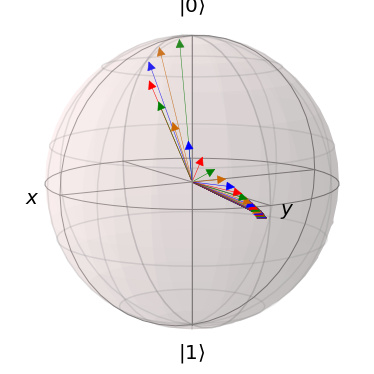

In [22]:
b = qt.Bloch()
b.add_states([psi(pt) for pt in pts],kind="vector")
b.view=[-30,10]
b.vector_width=.5
b.show()

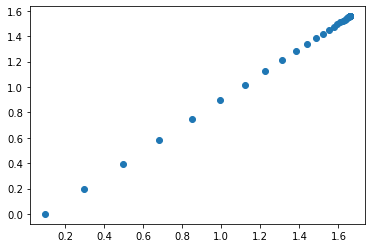

In [23]:
x = [x for (x,y) in pts]
y = [y for (x,y) in pts]
plt.scatter(x,y)

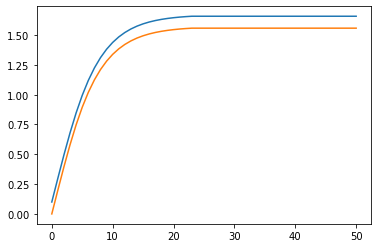

In [24]:
plt.plot(pts)

In [25]:
tlist = np.linspace(0,2*np.pi/3,50)

In [26]:
result = qt.sesolve(qt.sigmay(),psi((0.1,0)),tlist=tlist)

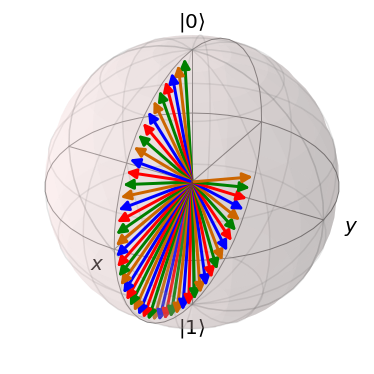

In [27]:
bbb = qt.Bloch()
bbb.add_states(result.states)
bbb.show()

------------------
## With Runge-Kutta

Solve the ODE 
$$ \frac{dx_j}{dt} = -\Im(G)^{jk}\Re(\langle\partial_k\psi(x(t))\mid H\mid \psi(x(t))\rangle) $$

$$ f(t,y)_j = \big(-\Im(G)^{jk}\Re(\langle\partial_k\psi(x(t))\mid H\mid \psi(x(t))\rangle)\big)_j $$

In [28]:
H=qt.sigmay()

In [29]:
def RHS(t,y):
    imG = linalg.inv(np.imag(G(psi,y)))
    reGrad = np.real(grad(psi,y,H))
    return np.array(-imG*reGrad).flatten()

In [30]:
times = np.linspace(0,2*np.pi/3,50)

In [31]:
result = integrate.solve_ivp(fun=RHS, t_span=(times[0],times[-1]), y0=(.12,0),t_eval=times, method="RK45")

In [32]:
pts=result.y

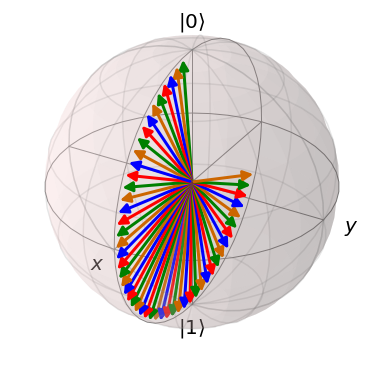

In [33]:
b = qt.Bloch()
b.add_states([psi((pts[0][j], pts[1][j]))
             for j in range(len(pts[0]))], kind="vector")
# b.view=[-90,30]
b.show()

Convert this to a script/function. Input should be a `state parametrization`, a `Hamiltonian` and optionally a `parametrized gram-matrix`.Also details like an `initial parameter set`, `start` and `end time`, `number of points` etc. should be provided. The output should be a list of parameter points. 

In [38]:
def tdvp_solver(state_param: Callable[[NDArray], qt.Qobj()],
                hamiltonian: qt.Qobj(),
                x_0: tuple,
                time_points: NDArray,
                gram_matrix: Callable[[NDArray], NDArray] = None,
                gradient: Callable[[NDArray], NDArray] = None):
                
    psi = state_param
    H = hamiltonian

    def finitediff(func: Callable[[Iterable[float]], qt.Qobj], epsilon: float = 1e-10) -> Callable[[Iterable[float]], qt.Qobj]:
        def dfunc(params):
            params = tuple(params)
            difference = list()
            for i in range(2):
                p_params = list(params)
                p_params[i] += epsilon
                difference.append((func(p_params)-func(params))/epsilon)
            return difference
        return dfunc

    def gen_grad(psi: Callable[[Iterable[float]], qt.Qobj], pars: Iterable[float], H: qt.Qobj = qt.sigmax()) -> np.matrix:
        pars = tuple(pars)
        dpsi = finitediff(psi)
        out = np.matrix([
            (dpsi(pars)[k].dag()*H*psi(pars)).full()[0][0]
            for k in range(2)]).T
        return out

    def gen_gram(psi: Callable[[Iterable[float]], qt.Qobj], pars: Iterable[float]) -> np.matrix:
        pars = tuple(pars)
        dpsi = finitediff(psi)
        return np.matrix([[
            ((dpsi(pars)[j]).dag()*dpsi(pars)[k]).full()[0][0]
            for k in range(2)] for j in range(2)])  # order of j,k must be correct -> j should be rows, k should be columns

    if gradient is None:
        grad = gen_grad
    else:
        grad = gradient

    if gram_matrix is None:
        gram = gen_gram
    else:
        gram = gram_matrix

    def RHS(t, x):
        imag_gram = linalg.inv(np.imag(gram(psi, x)))
        real_grad = np.real(grad(psi, x, H))
        return np.array(-imag_gram*real_grad).flatten()

    print('Solving ...')
    result = integrate.solve_ivp(fun=RHS,
                                 t_span=(time_points[0], time_points[-1]),
                                 y0=x_0,
                                 t_eval=time_points,
                                 method="RK45")
    # print(f"{result.status} with {'success' if result.success else 'no success'}")
    print(result.message)
    pts = result.y
    return result,{
        result.t[j]: (pts[0][j], pts[1][j])
        for j in range(len(pts[0]))
    }


In [55]:
result, tx = tdvp_solver(psi,qt.sigmay()+qt.sigmax(),(0.1,0),np.linspace(0,2*np.pi/3,100))

Solving ...
The solver successfully reached the end of the integration interval.


In [60]:
def plot_angles():
    fig = go.Figure(data=go.Scatter3d(
    x=result.y[0], y=result.y[1], z=result.t,
    marker=dict(
        size=4,
        color=result.t,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
    ))

    fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        xaxis_title='theta',
        yaxis_title='phi',
        zaxis_title='time',
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio=dict(x=1, y=1, z=0.7),
        aspectmode='manual'
        ),
    )

    fig.show()

plot_angles()


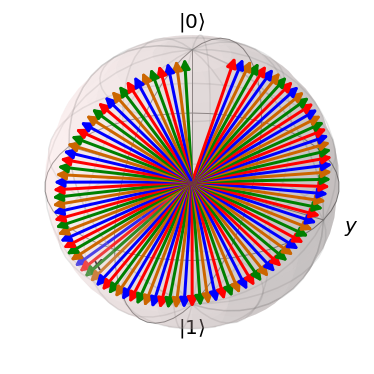

In [61]:
b = qt.Bloch()
b.add_states([psi(val)for val in tx.values()], kind="vector")
# b.view=[-90,30]
b.show()

In [ ]:
qt.